In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

import plotly.graph_objects as go

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

[Source](https://www.kaggle.com/code/leomauro/anomaly-detection-streaming-data-evaluation/data?select=server_res_eth1out_curve_61.csv)

In [28]:
data1=pd.read_csv('cpu4.csv')
for i in range(len(data1)):
    data1['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(data1['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in data1.columns if i not in ['timestamp']]
for col in cols:
    data1[col]=pd.to_numeric(data1[col])
data1['timestamp'] = pd.to_datetime(data1['timestamp'])
    
# data2=pd.read_csv('g.csv')
# for i in range(len(data2)):
#     data2['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(data2['timestamp'].iloc[i])
    
# data3=pd.read_csv('rver_res_eth1out_curve_6.csv')
# for i in range(len(data3)):
#     data3['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(data3['timestamp'].iloc[i])
    
# data4=pd.read_csv('server_res_eth1out_curve_61.csv')
# for i in range(len(data4)):
#     data4['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(data4['timestamp'].iloc[i])

In [29]:
data1

,timestamp,value,label
0,2016-07-24 20:00:00,0.847300,0
1,2016-07-24 20:05:00,-0.036137,0
2,2016-07-24 20:10:00,0.074292,0
3,2016-07-24 20:15:00,0.074292,0
4,2016-07-24 20:20:00,-0.036137,0
...,...,...,...
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0


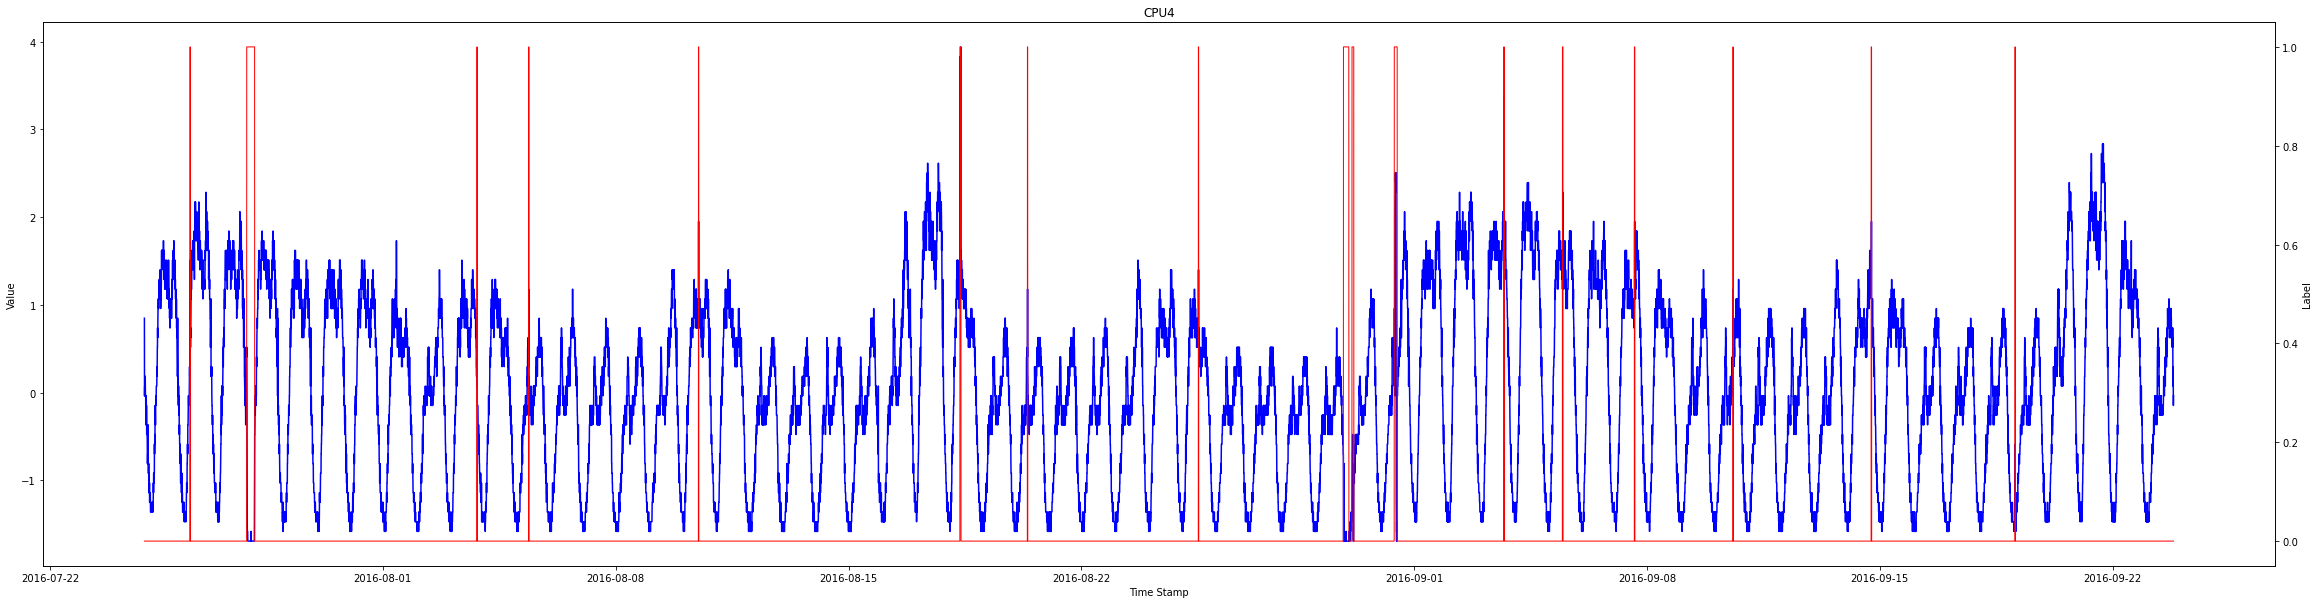

In [30]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(data1['timestamp'], data1['value'], color='blue')
ax2a.plot(data1['timestamp'], data1['label'], color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('Value')
ax2a.set_ylabel('Label')
ax2d.title.set_text('CPU4')

In [31]:
# We will use the CPU 4 dataset for our contextual anomalies detection
data1['timestamp'] = pd.to_datetime(data1['timestamp'])
data1['timestamp'].min(), data1['timestamp'].max()

(Timestamp('2016-07-24 20:00:00'), Timestamp('2016-09-23 19:55:00'))

In [49]:
time=data1['timestamp']
time_point=time[round(len(data1)*0.8)]
time_point

Timestamp('2016-09-11 15:10:00')

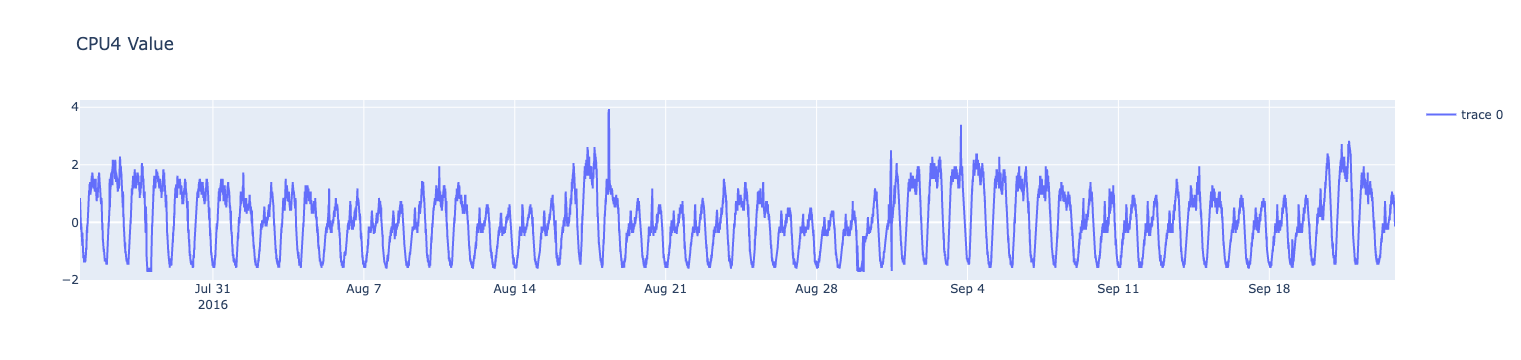

In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['timestamp'], y=data1['value']))
fig.update_layout(showlegend=True, title='CPU4 Value')
fig.show()

In [51]:
train, test = data1.loc[data1['timestamp'] <= time_point], data1.loc[data1['timestamp'] > time_point] #I took 2/3 of the data for the trainning and the rest for the testing
train.shape, test.shape

((14055, 3), (3513, 3))

In [52]:
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [53]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (14025, 30, 1)
Testing shape: (3483, 30, 1)


In [54]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [55]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
395/395 [==============================] - 22s 50ms/step - loss: 0.3255 - val_loss: 0.2690
Epoch 2/100
395/395 [==============================] - 19s 48ms/step - loss: 0.2983 - val_loss: 0.2842
Epoch 3/100
395/395 [==============================] - 21s 52ms/step - loss: 0.2954 - val_loss: 0.2686
Epoch 4/100
395/395 [==============================] - 25s 62ms/step - loss: 0.2962 - val_loss: 0.2688
Epoch 5/100
395/395 [==============================] - 23s 59ms/step - loss: 0.2939 - val_loss: 0.2688
Epoch 6/100
395/395 [==============================] - 25s 63ms/step - loss: 0.2949 - val_loss: 0.2735


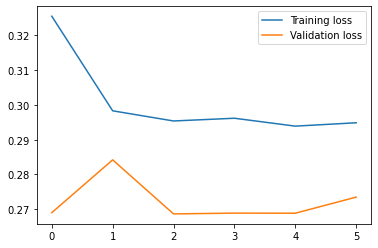

In [56]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [57]:
model.evaluate(X_test, y_test)

109/109 [==============================] - 4s 33ms/step - loss: 0.2874


0.2874181866645813

Reconstruction error threshold: 2.4026571418778175


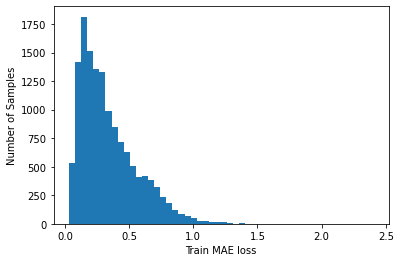

In [58]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

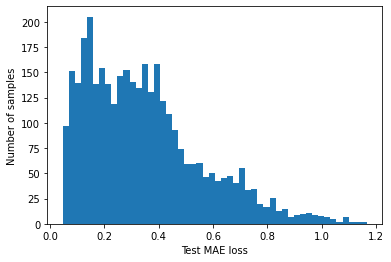

In [59]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

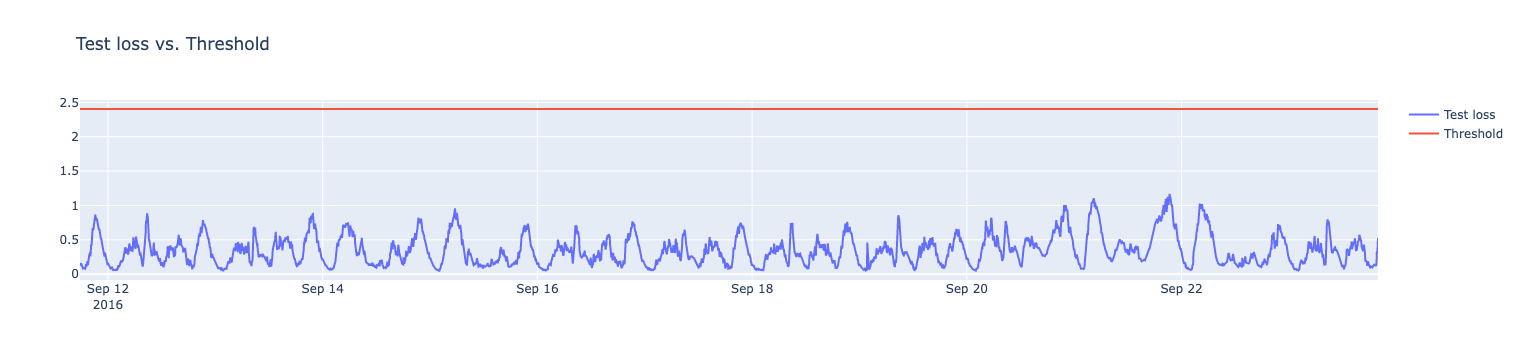

In [60]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [61]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(0, 6)

In [62]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['value']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['value']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.84025332  0.73005063  0.84025332 ...  0.06883453 -0.15157083
 -0.04136815].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.